# Can machine "learn" something from the texts?

## Introduction

One important aspect of the Digital Humanity, one interesting thing is around the question -- _"Can we let the machine learn from the texts, to understand the texts?"_ <br/>
In order to answer that question, I think first we should define "learn". What does learn mean? To what degree can we say it "understand" the texts? Suppose that we give it some texts, and during some computation, it gives out some outputs, generates some texts -- something that makes sence -- maybe we could say it "learn" something, because otherwise it could only give some random output and totally messed up. <br/>
If we deep further in this question, we can easily figure out a way to test that -- that is, if the machine really "learn" something and gives the output based on the given input, then, if we change the input, the output should be different, right? <br/>
So basically, what I try to do is that, I try to design a kind of experiment. I put two different genres into the machine, and to see whether the outputs are different(different according to the genres), if they are, then maybe we can say it actually "learn" something, because the machine is not only generating the texts, but also generating the "different" texts; and if not, maybe we need to find another way to figure this out.

## How
In order to solve this problem, I take it apart to several steps as follows:<br/>

1. Find two different subjects, and see how different they are.
2. Train two models based on the two different subjects.
3. Let the model predicts -- gives out some outputs, and to see if they are different.

And here we go.

### I. Find two different subjects

First of all, import some libs that are quite useful.

In [73]:
import numpy as np
import nltk
import requests
import collections
import json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
import pandas as pd
import collections
%matplotlib inline

The following cell are some functions that helps to get some texts, I will explain them individually<br/>
1. ```def getAndParseTexts(url)```<br/>
This function takes url and use the ```request``` to get the content from the website, and finally turn it into plain texts.
2. ```def getGenreTexts(genre, n)```<br/>
This function takes genre like "Humorous stories" and the number of the essays you want to fetch. You can find all subjects on [genres](http://corpus-db.org/api/subjects) I use the [CorpusDB](http://corpus-db.org/) as database. And the function use the parameter ```genre``` to filter all the subjects, and then fetch all the books under this specific genre, finally, return the plain texts. And there are some ids in CorpusDB that dosen't have content, I just throw these ids away, so the length of the returning list maybe dosen't match the parameter ```n``` you want exactly.
3. ```def cleanAndTokenizer(text)```<br/>
Since the following computaiona are based on the token level, so it it convenient to tokenize the text here. And I use the function ```RegexpTokenizer``` to filter all the other tokens like punctuations away and only remain the characters.
4. ```def print_ngrams(n=5)```<br/>
This function is just for fun, you can print the most frequent n-grams of the texts, default 5-grams.
5. ```PCA_plot(first_texts, first_titles, second_texts, second_titles)```<br/>
This fucntion plot the result after using ```PCA``` on the input texts. There are only 2 dimension remained after PCA. And the titles are prepared for the annotations.

In [74]:
def getAndParseTexts(url): 
    response = requests.get(url)
    if response.ok: 
        text = json.loads(response.text)
    return text


def getGenreTexts(genre, n): 
    response = getAndParseTexts("http://corpus-db.org/api/subject/" + str(genre))
    texts = []
    titles = []
    for r in response[:n]:
        id = r['id']
        title = r['title']
        try:
            texts.append(getAndParseTexts("http://corpus-db.org/api/id/"+str(id)+"/fulltext")[0]['text'])
            titles.append(title)
        except:
            print("id: " + str(id) + " is invalid, please check in the CorpusDB.")
    return titles, texts


def cleanAndTokenize(text):
    word_tokenizer = nltk.RegexpTokenizer(r"\w+")
    return word_tokenizer.tokenize(text)


def print_ngrams(n=5):
    print(list(collections.Counter(list(nltk.ngrams(cleanAndTokenize(" ".join(love_list)),n=5))).most_common(10)))
    return
    

def PCA_plot(first_texts, first_titles, second_texts, second_titles):
    tfidf = TfidfVectorizer(tokenizer=nltk.word_tokenize, max_features=400)
    tfMatrix = tfidf.fit_transform(first_texts + second_texts)
    pca = PCA(2)
    pcaOut = pca.fit_transform(tfMatrix.todense())
    df = pd.DataFrame(pcaOut, index=first_titles + second_titles, 
                      columns=['C1', 'C2']) 
    ax = df.plot(x='C1', y='C2', kind='scatter', figsize=(5,5), c=list('r'*len(first_titles) + 'b'*len(second_titles)))
    for key, value in df.iterrows():
        ax.annotate(key, value)

Then, I deliberately choose two genres that are quite different -- one is _Tragedies_ and the other is _Humorous stories_. We really know they are quite different, but what I want to do is to let the machine know this as well. Are they really different in the eyes of the machine? If they are, we could put them to train the model, otherwise we may choose another two -- because this experiment is based on the condition that the inputs are different.<br/>
And as you could see the figure below, after the ```PCA``` transformation, they are really taken apart. We could easily draw a boundary to seperate them, which means, we could use these two genres of texts as inputs.<br/>
_PS_: some ids are invalid in CorpusDB, I just drop them. You could see more details in the ```def getGenreTexts(genre, n)``` above.

id: 875.0 is invalid, please check in the CorpusDB.
id: 269.0 is invalid, please check in the CorpusDB.


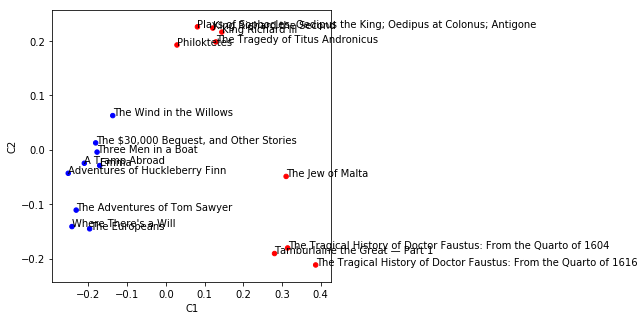

In [75]:
tragedies_titles, tragedies_list = getGenreTexts("Tragedies", 10)
humor_titles, humor_list = getGenreTexts("Humorous stories", 10)
PCA_plot(tragedies_list, tragedies_titles, humor_list, humor_titles)

### II. Train the model
Here are the core of the whole experiment. I did lots of research here. <br/>
What I want to do is to train a model that could generate sentences after training. And there are several ways I can do about this. According to my research, the methods fall into at least three categories:
1. Using the rule of the language. For example, the grammer, the syntax, and the structure of the sentence. We can exam the components that construct the sentences, and use these rule to put the words together. -- These methods focuse more on the language itself.
2. Some traditional algorithms. For example, counting the word frequency, using the Markov chain. By saying "traditional", I mean the algorithms contrast to the ML methods, specificly, the neural network approach. -- These methods focuse more on using mathmatics, treats the texts as data, dosen't care the structure or the meaning so much.
3. Machine learn, typically, neural network. -- These methods focuse more on using linear algebra and calculus. Although it is hard to interprete what is happening when we apply some matrix computations, but the result sometimes is really amazing.

What I choose is the third one -- neural network, more specifically, Recurrent Neural Network.(I will call it as RNN for short)<br/>
The reason is that the first kind of methods need lots of knowledge about the language, there are too many things, too many aspects need to take into account; the second kind of methods are useful and effective, but it somehow dosen't use the whole sentences, in another word, the words have some inter-connections with each other, and it is important to take advantage of this information when we train the model. So that is why I choose RNN.<br/>
Basically, the simplest RNN can be demonstrated as following figure:<br/>
![RNN](https://miro.medium.com/max/1254/1*xLcQd_xeBWHeC6CeYSJ9bA.png)<br/>
You can see that different from the tranditional neural network, the hidden layers(layers between the input and the output, which is "A" in the image above) not only take the "input", but also take something from the former state. You can image that there is something call "hidden vector" in the network itself besides the input. So this "hidden vector" can keep some information of the former state, and influence the state after. And it is clearer if you see the codes below:<br/>
```
class RNN:
  # ...
  def step(self, x):
    # update the hidden state
    self.h = np.tanh(np.dot(self.W_hh, self.h) + np.dot(self.W_xh, x))
    # compute the output vector
    y = np.dot(self.W_hy, self.h)
    return y
```
Here, we first calculate the new "hidden vector" based on the former "hidden vector" and the input, and then we calculate the output. And this new hidden vector would be used for the further calculation. By doing this, we could keep some information from the former state.(There are more details about this, and you can see some links in the _Citation_ part which explain this more deeply. I read all of them when I was doing the research, the paragraph above is just for a short explaination).<br/>
And after I figured out what the model is, and the mathmatical theory behind the model, this is time for me to implement it.<br/>
I searched on the website and found some codes about this medel. And the original codes had some drawbacks, I changed it in follow aspects:
1. Origial codes are based on character level, which means you put some characters to train it, and it predicts the following characters. I think it is a little bit inaccurate because if we do this, we must first let the model know how to spell the words, and this just add much more difficulties. If we base on the word level, there is no need to train the model for spelling the right words, which could save a lot of time and apparently, more accurate. It just focuses on the structure of sentences.
2. I change the original codes into an OOP version. Because we need to train two different models, and if it is OOP, then it is easier for me to do such a thing. And also, it is more readable and reuseble. It is very easy to build the model as you can see later -- just four lines, we can train our own model and play with it interactively!!!
3. The original codes didn't use any framework like _TensorFlow_ or _Pytorch_, and I want to rewrite it in a pytorch version. I try several times, and although it dosen't give errors, it is too slow, I don't know why, I just paste the code in the very end, and maybe it is because I don't use GPU. But I think just use the following codes is fine.

Basically, train a model is doing these step repeatedly:
1. Farword, give the model some inputs, let the model compute some output. But these outputs are not perfect, that is why we train it repeatedly.
2. Define loss function, use this function to judge how different between the generated outputs and the real ones.
3. Back propagation. Calculate the calculus based on the loss function, and adjust the parameters in the model little by little, to let the outputs closer to the real ones.

And here, I want to express the codes a little bit:
1. ```def _init_(self, text, learning_rate=1e-1, hidden_size=100 ,seq_length=25))``` -- This  fucntion is used for the initing some parameters inside the model. You could put ```text``` into it which is used for the training; ```learning_rate``` is used when back-propagation, it shouldn't be too large; ```hidden_size``` is the hidden vector's dimention; ```seq_length``` is the sentencve length put to train in the same time.
2. ```def extractMostFrequentTokens(self, text)``` -- This function extract most frequent 4000 tokens in the text, otherwise there would be much more dimensions.
3. ```def lossFun(self, inputs, targets, hprev)``` -- This fucntion is used in the back propagation step, calculate the gradient of all parameters.
4. ```def sample(self, h, seed_ix, n)``` -- This function generates texts.
5. ```def train(self, iternums=10000)``` -- This function is used for training.
6. ```def predict(self, inputs, length=30)``` -- This function generates texts, it uses ```sample``` as sub-function.

In [78]:
"""
Part of the codes are from:
    https://gist.github.com/karpathy/d4dee566867f8291f086
    Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
    BSD License

I change it to OOP, also, the original model is based on the letter instead of the words or tokens
And I make it based on words/tokens level.
"""
class RNN():
    def __init__(self, text, learning_rate=1e-1, hidden_size=100 ,seq_length=25):
        tokenizer = nltk.RegexpTokenizer(r"\w+")
        text = tokenizer.tokenize(text)
        self.text = self.extractMostFrequentTokens(text)
        
        self.hidden_size = hidden_size  # size of hidden layer of neurons
        self.seq_length = seq_length  # number of steps to unroll the RNN for
        self.learning_rate = learning_rate
        
        chars = list(set(text))
        self.data_size, self.vocab_size = len(self.text), len(chars)
        print('data after filtering has %d tokens, %d unique.' % (self.data_size, self.vocab_size))
        self.char_to_ix = {ch: i for i, ch in enumerate(chars)}
        self.ix_to_char = {i: ch for i, ch in enumerate(chars)}
        
        self.Wxh = np.random.randn(self.hidden_size, self.vocab_size) * 0.01  # input to hidden
        self.Whh = np.random.randn(self.hidden_size, self.hidden_size) * 0.01 # hidden to hidden
        self.Why = np.random.randn(self.vocab_size, self.hidden_size) * 0.01 # hidden to output
        self.bh = np.zeros((self.hidden_size, 1))  # hidden bias
        self.by = np.zeros((self.vocab_size, 1))  # output bias
        self.hprev = np.zeros((self.hidden_size, 1))  # reset RNN memory
        self.smooth_loss = -np.log(1.0/self.vocab_size)*self.seq_length # loss at iteration 0
        
        self.losses = []
    

    def extractMostFrequentTokens(self, text):
        most_common = collections.Counter(text).most_common(4000)
        most_common = [i[0] for i in most_common]
        return list(filter(lambda a: a!= " ", [i if i in most_common else ' ' for i in text]))


    def lossFun(self, inputs, targets, hprev):
        """
        inputs,targets are both list of integers.
        hprev is Hx1 array of initial hidden state
        returns the loss, gradients on model parameters, and last hidden state
        """
        xs, hs, ys, ps = {}, {}, {}, {}
        hs[-1] = np.copy(hprev)
        loss = 0
        # forward pass
        for t in range(len(inputs)):
            xs[t] = np.zeros((self.vocab_size, 1))  # encode in 1-of-k representation
            xs[t][inputs[t]] = 1
            hs[t] = np.tanh(np.dot(self.Wxh, xs[t]) + np.dot(self.Whh, hs[t - 1]) + self.bh)  # hidden state
            ys[t] = np.dot(self.Why, hs[t]) + self.by  # unnormalized log probabilities for next chars
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))  # probabilities for next chars
            loss += -np.log(ps[t][targets[t], 0])  # softmax (cross-entropy loss)
        # backward pass: compute gradients going backwards
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(hs[0])
        for t in reversed(range(len(inputs))):
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1  # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
            dWhy += np.dot(dy, hs[t].T)
            dby += dy
            dh = np.dot(self.Why.T, dy) + dhnext  # backprop into h
            dhraw = (1 - hs[t] * hs[t]) * dh  # backprop through tanh nonlinearity
            dbh += dhraw
            dWxh += np.dot(dhraw, xs[t].T)
            dWhh += np.dot(dhraw, hs[t - 1].T)
            dhnext = np.dot(self.Whh.T, dhraw)
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam)  # clip to mitigate exploding gradients
        return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs) - 1]


    def sample(self, h, seed_ix, n):
        """
        sample a sequence of integers from the model
        h is memory state, seed_ix is seed letter for first time step
        """
        x = np.zeros((self.vocab_size, 1))
        x[seed_ix] = 1
        ixes = []
        for t in range(n):
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.vocab_size), p=p.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[ix] = 1
            ixes.append(ix)
        return ixes
    
    
    def train(self, iternums=10000):
        mWxh, mWhh, mWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        mbh, mby = np.zeros_like(self.bh), np.zeros_like(self.by)  # memory variables for Adagrad
        p = 0
        n = 0
        smooth_loss = -np.log(1.0/self.vocab_size)*self.seq_length # loss at iteration 0
        while True:
            # prepare inputs (we're sweeping from left to right in steps seq_length long)
            if p + self.seq_length + 1 >= len(self.text) or n == 0:
                p = 0  # go from start of data
            # change data to text
            inputs = [self.char_to_ix[ch] for ch in self.text[p:p + self.seq_length]]
            targets = [self.char_to_ix[ch] for ch in self.text[p + 1:p + self.seq_length + 1]]

            # sample from the model now and then
            if n % 1000 == 0:
                sample_ix = self.sample(self.hprev, inputs[0], 20)
                txt = ' '.join(self.ix_to_char[ix] for ix in sample_ix)
                print('----\n %s \n----' % (txt,))
                if n >= iternums:
                    np.savez("matrix.npz", self.Wxh, self.Whh, self.Why, self.bh, self.by, self.hprev, np.array([p]), np.array([n]), np.array([self.smooth_loss]))
                    break

            # forward seq_length characters through the net and fetch gradient
            loss, dWxh, dWhh, dWhy, dbh, dby, self.hprev = self.lossFun(inputs, targets, self.hprev)


            self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
            if n % 100 == 0:
                self.losses.append(self.smooth_loss)
                if n % 1000 == 0:    
                    print('iter %d, loss: %f' % (n, self.smooth_loss))  # print progress

            # perform parameter update with Adagrad
            for param, dparam, mem in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by],
                                          [dWxh, dWhh, dWhy, dbh, dby],
                                          [mWxh, mWhh, mWhy, mbh, mby]):
                mem += dparam * dparam
                param += -self.learning_rate * dparam / np.sqrt(mem + 1e-8)  # adagrad update

            p += self.seq_length  # move data pointer
            n += 1  # iteration counter
            
            
    def predict(self, inputs, length=30):
        sample_ix = self.sample(self.hprev, [self.char_to_ix[i] for i in nltk.word_tokenize(inputs)], length)
        txt = ' '.join(self.ix_to_char[ix] for ix in sample_ix)
        return '----\n %s \n----' % (inputs + " " + txt,)
        

Here, I put one of the humorous stories into the model, I just train it 10000 times.

In [79]:
rnn_humor = RNN(humor_list[0][10000:30000], learning_rate=0.1)
rnn_humor.train(10000)

data after filtering has 3828 tokens, 1245 unique.
----
 fix evidence LIKE England straitened never lecture struggling started d swimming fragrance stood oughtn the they tripping whitewashin coward for 
----
iter 0, loss: 178.172275
----
 He to the Mars ain I I pretty would I take to a head III Tom and the always with 
----
iter 1000, loss: 171.354173
----
 each and the never by her steal resolution of the and on I middle you You on his marched on 
----
iter 2000, loss: 150.463542
----
 how turned answered philosopher think in t for the stabboard Then and stuck been powerful mean speed field of now 
----
iter 3000, loss: 124.098027
----
 for the long eye fighting trash a house partiality after would themselves him on the good and little to with 
----
iter 4000, loss: 99.786134
----
 his innocents ran offered girls so The cares and unlock the go that of Tom s power world to look 
----
iter 5000, loss: 79.039326
----
 said them took that don t and declined in T firing ll day dreading str

In [80]:
inputs = input()
humor_output = rnn_humor.predict(inputs, 1000)

 you


In the cell above, I give the model some key words to start with the generation. <br/>
PS: The results are not always the same, because there are some random choosings of the words.<br/>
And then, I train the second model. Here I do exactly the same thing, but I change the inputs to train the model.

In [81]:
rnn_tragedy = RNN(tragedies_list[0][10000:30000], learning_rate=0.1)
rnn_tragedy.train(10000)

data after filtering has 3666 tokens, 1261 unique.
----
 guilt lore profits clean vague race deny robes preferring Give boot tricksy spoken Mind _I_ taxest sister wouldst Dost angel 
----
iter 0, loss: 178.491502
----
 to sign land my doom shrinks shrift I Thou CREON thou by presume is OEDIPUS to hadst man this thine 
----
iter 1000, loss: 174.962494
----
 I reach I flint to all Did say all Give It a Thou own the Is shares to rage I 
----
iter 2000, loss: 161.546503
----
 art Therefore no pretend what are prophet when her goes Should men on the By command upland They And man 
----
iter 3000, loss: 143.770110
----
 not I boot thee And I pray own clear so lightning my closer conferred of this I as the heard 
----
iter 4000, loss: 121.438345
----
 mood in envy count this wise keep huntress sister Whose tricksy self insolently for slanderer thou perished st if if 
----
iter 5000, loss: 101.234076
----
 the remedy Ye Wasted gold rend he him and best the seer could I privity to he But lightn

In [88]:
inputs = input()
tragedy_output = rnn_tragedy.predict(inputs, 1000)

 you


In [89]:
humor_outputs = [humor_output[i: i+250] for i in range(0, 1001, 250) if i<=len(humor_output)-250]
tragedy_outputs = [tragedy_output[i: i+250] for i in range(0, 1001, 250) if i<=len(tragedy_output)-250]

I divide the outputs into five equal parts, and use ```PCA``` to draw a figure about these.

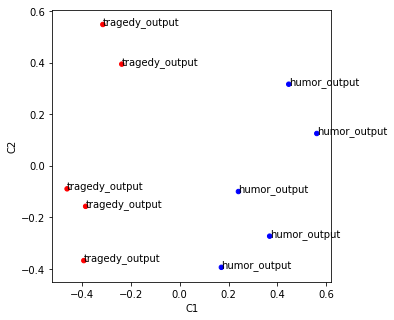

In [90]:
PCA_plot(tragedy_outputs, ['tragedy_output']*5, humor_outputs, ['humor_output']*5)

## Conclusion
It is amazing and exciting to see that the ouputs are quite different and could be taken apart after PCA, considering that I just train it 10,000 times, so the result has already been shocking. And maybe this could be interpreted as that the machine can "learn" from the different subjects. And I also excited because this model is totally interactive and we can put almost anything into the model, like diaries or even codes, and the model would give out some sentences which are really amazing.

## Github
I put this in the github, and every can play with it !<br/>
https://github.com/CaesarRoot/UCB-Digital-Humanity-Final-Project.git

## Citations
1. http://corpus-db.org/
2. https://medium.com/explore-artificial-intelligence/an-introduction-to-recurrent-neural-networks-72c97bf0912
3. https://gist.github.com/karpathy/d4dee566867f8291f086
4. http://karpathy.github.io/2015/05/21/rnn-effectiveness/
5. https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79

## Appendix: Pytorch version
The last part is a pytorch version, it is too too slow, and has some warnings when I run it under the _Pycharm_.

In [ ]:
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
https://gist.github.com/karpathy/d4dee566867f8291f086
http://karpathy.github.io/2015/05/21/rnn-effectiveness/
https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79
"""

import nltk
import requests
import collections
import numpy as np
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F

# data I/O
data = requests.get('https://raw.githubusercontent.com/JonathanReeve/course-computational-literary-analysis/gh-pages/_texts/moonstone.md').text  # should be simple plain text file
# ---------------------------
tokenizer = nltk.RegexpTokenizer(r"\w+")
text = tokenizer.tokenize(data)


def extractMostFrequentTokens(text):
    most_common = collections.Counter(text).most_common(2000)
    most_common = [i[0] for i in most_common]
    return list(filter(lambda a: a!= " ", [i if i in most_common else ' ' for i in text]))


text = extractMostFrequentTokens(text)
# ---------------------------

def one_hot_encode(inputs, vocab_size):
    xs = []
    for t in range(len(inputs)):
        xs.append(np.zeros((vocab_size, 1)))  # encode in 1-of-k representation
        xs[t][inputs[t]] = 1
    result = torch.from_numpy(np.array(xs).reshape((seq_length, vocab_size))).float()
    return result

chars = list(set(text))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# hyperparameters
hidden_size = 100  # size of hidden layer of neurons
seq_length = 25  # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = np.random.randn(hidden_size, vocab_size) * 0.01  # input to hidden
Whh = np.random.randn(hidden_size, hidden_size) * 0.01  # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size) * 0.01  # hidden to output
bh = np.zeros((hidden_size, 1))  # hidden bias
by = np.zeros((vocab_size, 1))  # output bias

# https://forums.fast.ai/t/runtimeerror-expected-object-of-scalar-type-long-but-got-scalar-type-int-for-argument-2-target/40248/10

# class RNN(nn.Module):
#
#     def __init__(self, vocab_size, hidden_size):
#         super(RNN, self).__init__()
#         self.vocab_size = vocab_size
#         self.hidden_size = hidden_size
#
#         self.Wxh = nn.Parameter(torch.randn(vocab_size, hidden_size))  # n_inputs X n_neurons
#         self.Whh = nn.Parameter(torch.randn(hidden_size, hidden_size))
#         self.Why = nn.Parameter(torch.randn(hidden_size, vocab_size))  # n_neurons X n_neurons
#
#         self.bh = nn.Parameter(torch.zeros(1, hidden_size))  # 1 X n_neurons
#         self.by = nn.Parameter(torch.zeros(1, vocab_size))
#
#     def forward(self, inputs, hprev):
#         hprev = torch.tanh(torch.mm(self.Wxh, inputs) + torch.mm(self.Whh, hprev) + bh)
#         outputs = torch.tanh(torch.mm(self.Why, hprev) + self.by)
#         return outputs, hprev
#
#     def init_hidden(self):
#         return torch.zeros(self.hidden_size, self.vocab_size)


class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, layers = 1):
        super(RNN, self).__init__()
        self.hidden_size = vocab_size

        self.rnn = nn.RNN(vocab_size, vocab_size, layers)

    def forward(self, inputs, hprev):
        output, h = self.rnn(inputs, hprev)
        return F.softmax(output, dim=2), h

    def init_hidden(self):
        return torch.randn(1, self.hidden_size).view(1, 1, self.hidden_size)


def sample(h, seed_ix, n):
    """
    sample a sequence of integers from the model
    h is memory state, seed_ix is seed letter for first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes


model = RNN(vocab_size, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
hprev = model.init_hidden()
n = 0
p = 0
while True:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p + seq_length + 1 >= len(data) or n == 0:
        p = 0  # go from start of data

    model.train()  # reset to train mode after iterationg through validation data
    model.zero_grad()
    inputs = [char_to_ix[ch] for ch in text[p:p + seq_length]]
    targets = [char_to_ix[ch] for ch in text[p + 1:p + seq_length + 1]]

    inputs = one_hot_encode(inputs, vocab_size).view(seq_length, 1, vocab_size)
    targets = one_hot_encode(targets, vocab_size).view(seq_length, vocab_size)
    # forward pass
    output, hprev = model.forward(inputs, hprev)
    loss = criterion(output, targets)
    loss.backward(retain_graph=True)

    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), 5)

    optimizer.step()


    if n % 100 == 0:
        print('iter %d, loss: %f' % (n, loss.item()))  # print progress

    p += seq_length  # move data pointer
    n += 1  # iteration counter
